### Qiskit circuit build

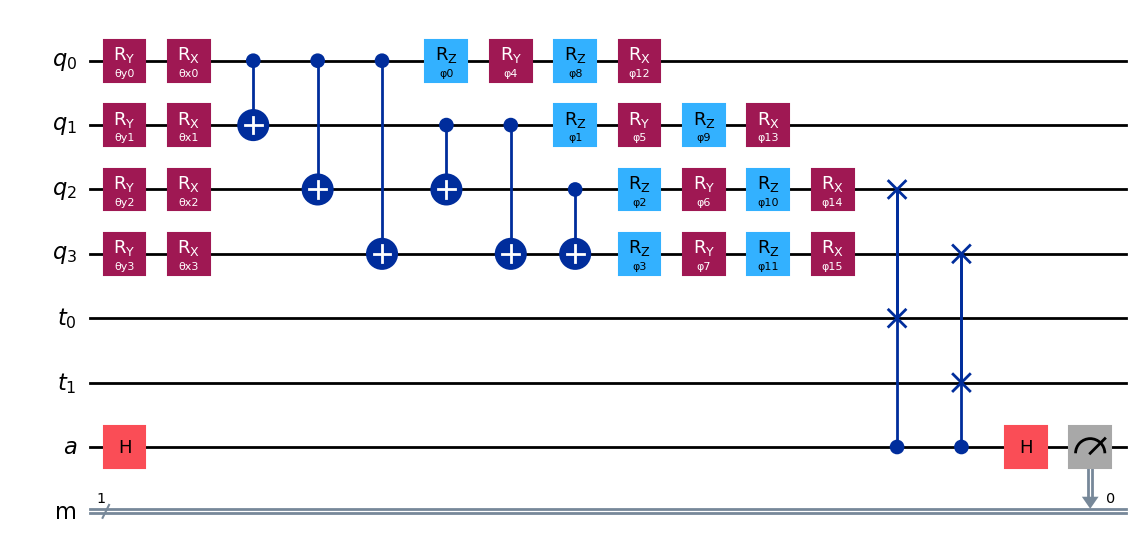

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

def make_circuit(nq, nt):
    # Registers (match the labels in your diagram)
    q = QuantumRegister(nq, "q")     
    t = QuantumRegister(nt, "t")    
    a = QuantumRegister(1, "a") 
    m = ClassicalRegister(1, "m")  

    qc = QuantumCircuit(q, t, a, m)

    # Features
    featsy = [Parameter(f"θy{i}") for i in range(nq)]
    featsx = [Parameter(f"θx{i}") for i in range(nq)]
    
    # Trainable parameters
    theta = [Parameter(f"φ{i}") for i in range(4*nq)]

    # Encoding layer
    for i in range(nq):
        qc.ry(featsy[i],  q[i])
        qc.rx(featsx[i],  q[i])

    # CNOT pattern
    for i in range(nq):
        for j in range(i+1, nq):
            qc.cx(q[i], q[j])
            
    # Rotation layer 
    for i in range(nq):
        qc.rz(theta[i],         q[i])
        qc.ry(theta[i+nq],      q[i])
        qc.rz(theta[i+2*nq],    q[i])
        qc.rx(theta[i+3*nq],    q[i])

    # Ancilla H
    qc.h(a[0])

    # Controlled-SWAPs
    for i in reversed(range(nt)):
        qc.cswap(a[0], q[-(i+1)], t[-(i+1)])

    # Final H + measure ancilla
    qc.h(a[0])
    qc.measure(a[0], m[0])

    return qc, theta

nq = 4
nt = 2
qc, theta = make_circuit(nq, nt)
qc.draw('mpl', fold=True)


In [2]:
bound = qc.assign_parameters({theta[0]: 0.1, theta[1]: 0.2, theta[2]: 0.3, theta[3]: 0.4})

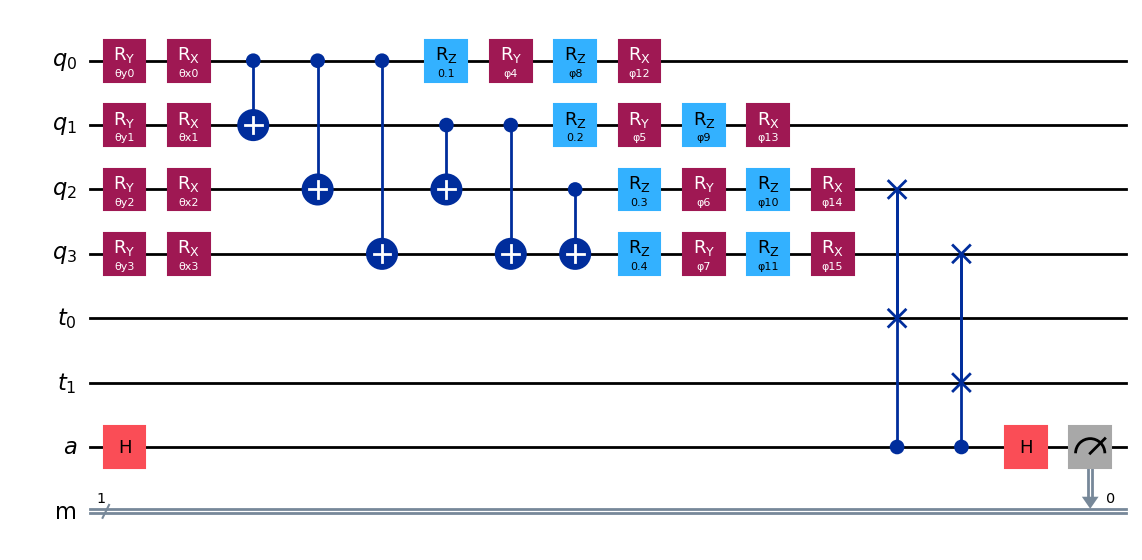

In [3]:
bound.draw('mpl', fold=True)

### Pennylane encoding

In [ ]:
import pennylane as qml
import numpy as np

def make_circuit_pennylane(nq, nt, shots=1000):
    # Name wires to mimic q/t/a registers
    q_wires = [f"q{i}" for i in range(nq)]
    t_wires = [f"t{i}" for i in range(nt)]
    a_wire = "a"

    dev = qml.device("default.qubit", wires=q_wires + t_wires + [a_wire], shots=shots)

    @qml.qnode(dev)
    def circuit(featsy, featsx, theta, return_projector=False):
        """
        featsy: shape (nq,)
        featsx: shape (nq,)
        theta:  shape (4*nq,)
        """

        # Encoding layer
        for i in range(nq):
            qml.RY(featsy[i], wires=q_wires[i])
            qml.RX(featsx[i], wires=q_wires[i])

        # CNOT pattern: for i<j, CX(q[i], q[j])
        for i in range(nq):
            for j in range(i + 1, nq):
                qml.CNOT(wires=[q_wires[i], q_wires[j]])

        # Rotation layer
        for i in range(nq):
            qml.RZ(theta[i],           wires=q_wires[i])
            qml.RY(theta[i + nq],      wires=q_wires[i])
            qml.RZ(theta[i + 2 * nq],  wires=q_wires[i])
            qml.RX(theta[i + 3 * nq],  wires=q_wires[i])

        # Ancilla H
        qml.Hadamard(wires=a_wire)

        # Controlled-SWAPs
        for i in reversed(range(nt)):
            qml.CSWAP(wires=[a_wire, q_wires[-(i + 1)], t_wires[-(i + 1)]])

        # Final H
        qml.Hadamard(wires=a_wire)

        # "Measure ancilla"
        if return_projector:
            # returns samples of projector onto |1>, i.e. 1 if ancilla is |1>, else 0
            return qml.sample(qml.Projector([1], wires=a_wire))
        else:
            # returns samples of PauliZ: +1 corresponds to |0>, -1 to |1>
            return qml.sample(qml.PauliZ(wires=a_wire))

    # return qnode + wire lists so you can reuse them
    return circuit, dev, q_wires, t_wires, a_wire


# --- Example usage (matches your nq=4, nt=2) ---
nq = 4
nt = 2

circuit, dev, q_wires, t_wires, a_wire = make_circuit_pennylane(nq, nt, shots=1000)

# Features
featsy = np.random.uniform(0, 2*np.pi, size=(nq,))
featsx = np.random.uniform(0, 2*np.pi, size=(nq,))

# Trainable params (φ0..φ_{4*nq-1})
theta = np.random.uniform(0, 2*np.pi, size=(4*nq,))

# Sample ancilla in Z basis (±1 samples)
samples_z = circuit(featsy, featsx, theta)
print("PauliZ samples (±1):", samples_z[:10])

# Or sample "bit-like" outcomes via projector onto |1>
samples_1 = circuit(featsy, featsx, theta, return_projector=True)
print("Projector(|1>) samples (0/1):", samples_1[:10])

# Draw the circuit
print(qml.draw(circuit)(featsy, featsx, theta))


PauliZ samples (±1): [ 1  1 -1  1  1 -1  1 -1  1  1]
Projector(|1>) samples (0/1): [0. 0. 1. 1. 1. 1. 1. 1. 0. 0.]
q0: ──RY(1.61)──RX(5.79)─╭●─╭●─╭●──RZ(5.37)──RY(0.21)──RZ(2.29)──RX(3.46)────────────────────
q1: ──RY(2.96)──RX(3.74)─╰X─│──│──╭●────────╭●─────────RZ(2.62)──RY(5.46)──RZ(0.84)──RX(2.07)
q2: ──RY(4.27)──RX(4.42)────╰X─│──╰X────────│─────────╭●─────────RZ(4.36)──RY(3.55)──RZ(3.18)
q3: ──RY(0.02)──RX(2.53)───────╰X───────────╰X────────╰X─────────RZ(1.40)──RY(4.66)──RZ(6.20)
t0: ─────────────────────────────────────────────────────────────────────────────────────────
t1: ─────────────────────────────────────────────────────────────────────────────────────────
 a: ──H──────────────────────────────────────────────────────────────────────────────────────

───────────────────────────┤           
───────────────────────────┤           
───RX(3.35)─╭SWAP──────────┤           
───RX(3.22)─│─────╭SWAP────┤           
────────────├SWAP─│────────┤           
────────────│─────├SWAP───